# Regression
Let's go back to our weather dataset. Instead of the binary `BBQ_weather` label we could try to predict a continuous value.

Let's go back to our original dataset

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
%ls data

weather_prediction_dataset.csv  weather_test.csv  weather_train.csv


In [3]:
data = pd.read_csv('data/weather_prediction_dataset.csv')
data.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-15.2,-17.0,-13.4,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,-13.7,-15.0,-12.3,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-9.2,-12.5,-5.8,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,-5.6,-7.0,-4.2,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-7.6,-9.4,-5.8,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


Let us try to predict the number of sunshine hours in Basel based in the previous day. We will have to create the new labels.

We will have to select our 3 years of data again. Then we create a new column that will show the number of sunshine hours in Basel on the next day.

In [4]:
n_rows = 365*3
weather_3years = data[:n_rows].drop(columns=['DATE', 'MONTH'])
sunshine_tomorrow = data[1:n_rows + 1]['BASEL_sunshine'].values

sunshine_tomorrow.mean()

4.531780821917808

We will have to split our training and test set again:

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(weather_3years.values, sunshine_tomorrow, test_size=0.3, random_state=0)

We will have to normalize the input again as well

Now that we have prepared our data we can start training our classifier. Let's start with a simple linear regression model.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [7]:
pipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('model', LinearRegression()),
])

In [8]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', MinMaxScaler()), ('model', LinearRegression())])

This time we can't use a confusion matrix to check our model so we have to use different methods to compare performance.

In [9]:
pred_train= pipe.predict(X_train)
pred_test= pipe.predict(X_test)

<AxesSubplot:title={'center':'Performance on training set'}, xlabel='ground truth', ylabel='prediction'>

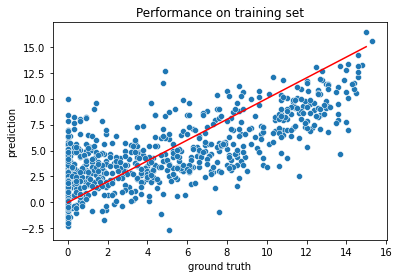

In [10]:
import matplotlib.pyplot as plt

plot = sns.scatterplot(x=y_train, y=pred_train)
plot.set_title('Performance on training set')
plot.set_xlabel('ground truth')
plot.set_ylabel('prediction')
plot.set_xbound((0, 16))
plot.set_ybound((-3, 16))

sns.lineplot(x=np.arange(16), y=np.arange(16), color='red')

<AxesSubplot:title={'center':'Performance on test set'}, xlabel='ground truth', ylabel='prediction'>

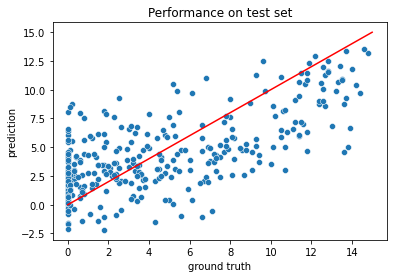

In [11]:
plot = sns.scatterplot(x=y_test, y=pred_test)
plot.set_title('Performance on test set')
plot.set_xlabel('ground truth')
plot.set_ylabel('prediction')
plot.set_xbound((0, 16))
plot.set_ybound((-3, 16))

sns.lineplot(x=np.arange(16), y=np.arange(16), color='red')

In [12]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, pred_train)

8.97647473137586

In [13]:
mean_squared_error(y_test, pred_test)

10.599978336514575

It is hard to say whether our results are good or bad. This depends on whether our prediction problem is hard or easy.

One way to evaluate can be to think of a very simple model and compare it against that.

### Exercise
Any ideas what could serve as a baseline model?

#### Answer
One idea could be to use the number of sunshine hours of the current day to predict the sunshine hours the next day. Consecutive days can have similar weather, right?

'Baseline MSE: 19.36031331592689'

'Predicted MSE: 8.97647473137586'

'Baseline MSE: 16.64887537993921'

'Predicted MSE: 10.599978336514575'

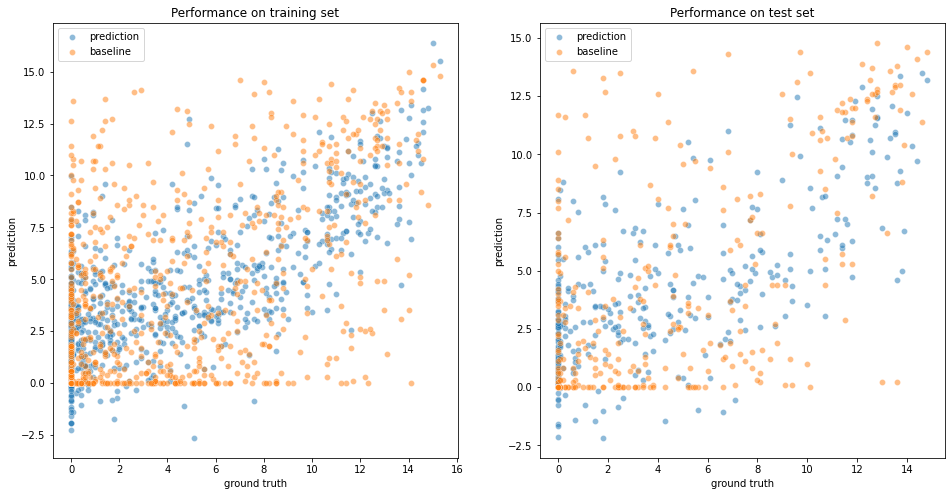

In [26]:
baseline_idx = weather_3years.columns.get_loc('BASEL_sunshine')

baseline_train = X_train[:, baseline_idx]
baseline_test = X_test[:, baseline_idx]

def plot_against_baseline(ground_truth, predicted, baseline, axis=None, label=''):
    plot = sns.scatterplot(x=ground_truth, y=predicted, label='prediction', alpha=0.5, ax=axis)
    plot.set_title(label)
    plot.set_xlabel('ground truth')
    plot.set_ylabel('prediction')
    plot.set_xbound((0, 16))
    plot.set_ybound((-3, 16))

    #sns.lineplot(x=np.arange(16), y=np.arange(16), color='red')
    sns.scatterplot(x=ground_truth, y=baseline, label='baseline', alpha=0.5, ax=axis)
    
    display(f'Baseline MSE: {mean_squared_error(ground_truth, baseline)}')
    display(f'Predicted MSE: {mean_squared_error(ground_truth, predicted)}')
    

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
plot_against_baseline(y_train, pred_train, baseline_train, axis=axes[0], label='Performance on training set')
plot_against_baseline(y_test, pred_test, baseline_test, axis=axes[1], label='Performance on test set')

As we can see, the baseline looks even more scatered than our prediction.



## Neural network
Let's create a non-linear model now. A well-known nonlinear model is the *neural network*. There are many libraries that are solely focused on neural networks, but we will not go into that today.

Scikit learn has the capability to create fairly simple neural networks. Let's create a model pipeline with a neural network!

We will use the class `MLPRegressor` for this. MLP stands for multi-layer perceptron.

Let's swap out our linear regression model for a neural network.

In [30]:
from sklearn.neural_network import MLPRegressor

neural_network = MLPRegressor()

layer_sizes = neural_network.hidden_layer_sizes

display(f'Hidden layer sizes: {layer_sizes},  number of layers: {len(layer_sizes)}')

'Hidden layer sizes: (100,),  number of layers: 1'

Let's plug our network into our training pipeline

In [31]:
neural_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('network', MLPRegressor())
])

In [32]:
neural_pipe.fit(X_train, y_train)

/home/dsmits/anaconda3/envs/py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scaler', MinMaxScaler()), ('network', MLPRegressor())])

'Baseline MSE: 19.36031331592689'

'Predicted MSE: 9.421509214638247'

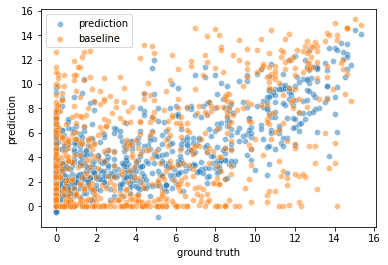

In [34]:
nn_train_pred = neural_pipe.predict(X_train)
nn_test_pred = neural_pipe.predict(X_test)

plot_against_baseline(y_train, nn_train_pred, baseline_train)

'Baseline MSE: 16.64887537993921'

'Predicted MSE: 9.712428851012197'

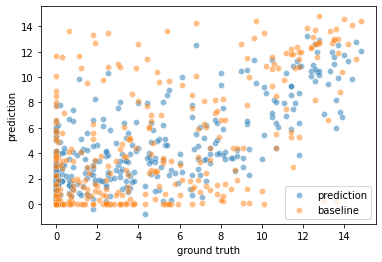

In [35]:
plot_against_baseline(y_test, nn_test_pred, baseline_test)